# 04 Visualisation

## Purpose:
This notebook visualises the performance of trained models on the classification task.

## Key Visualisations:
1. Training and validation loss/accuracy over epochs.
2. Confusion matrices for test set predictions.
3. Comparative bar charts for metrics (accuracy, mAP, training time).
4. Final conclusions on model performance.

## Outputs:
- Plots saved to `reports/graphs/`.
- Insights documented in `reports/conclusions.txt`.

In [3]:
# General imports
import os  # For file and directory operations
import time  # For tracking and logging training/evaluation time
import numpy as np  # For numerical computations and handling arrays
import pandas as pd  # For data manipulation and analysis
import csv  # For saving evaluation results to a CSV file

# Plotting libraries
import matplotlib.pyplot as plt  # For creating visualizations like line plots and bar charts
import seaborn as sns  # For enhanced visualizations like heatmaps and styled bar charts

# TensorFlow/Keras imports
import tensorflow as tf  # Core TensorFlow library
from tensorflow.keras.models import Model, load_model  # For creating and loading models
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D  # Layers for custom classification head
from tensorflow.keras.optimizers import Adam  # Optimizer for training
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For data preprocessing and augmentation
from tensorflow.keras.applications import ResNet50, DenseNet121, MobileNetV3Large  # Pre-trained architectures
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet  # Preprocessing for ResNet50
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_input_densenet  # Preprocessing for DenseNet121
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as preprocess_input_mobilenet  # Preprocessing for MobileNetV3

# Scikit-learn imports
from sklearn.metrics import precision_recall_curve, average_precision_score  # For computing mAP (Mean Average Precision)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # For confusion matrix calculations and visualization

Load Results and Metric

In [4]:
# Load evaluation results
results_file = ".model_evaluation_results.csv"
evaluation_results = pd.read_csv(results_file)

# Display the results
print(evaluation_results)

         Model      Loss  Accuracy  mAP  Training Time (seconds)
0     ResNet50  0.000288    1.0000    1                 14096.77
1  DenseNet121  0.000849    1.0000    1                 13621.39
2  MobileNetV3  0.000866    0.9999    1                  3229.71


Training/Validation Loss and Accuracy Plots

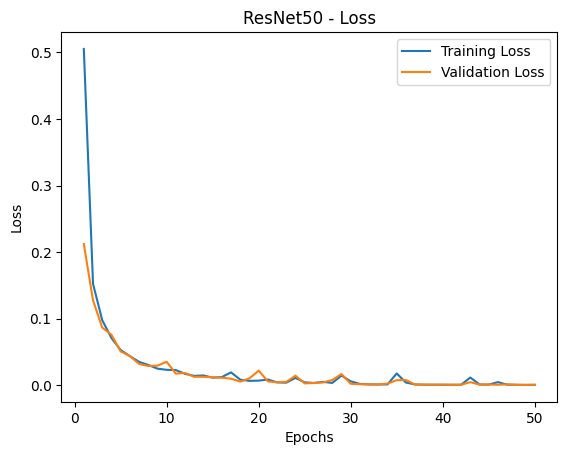

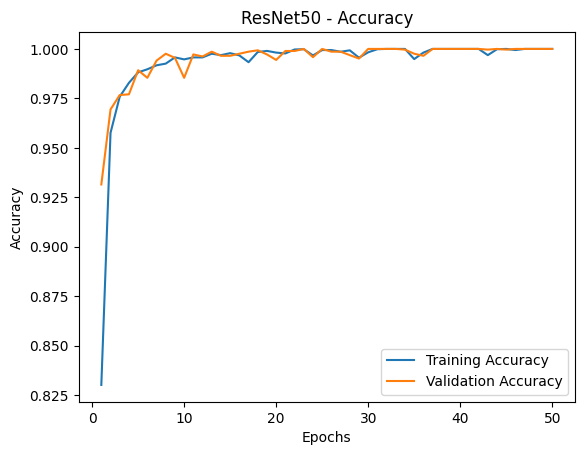

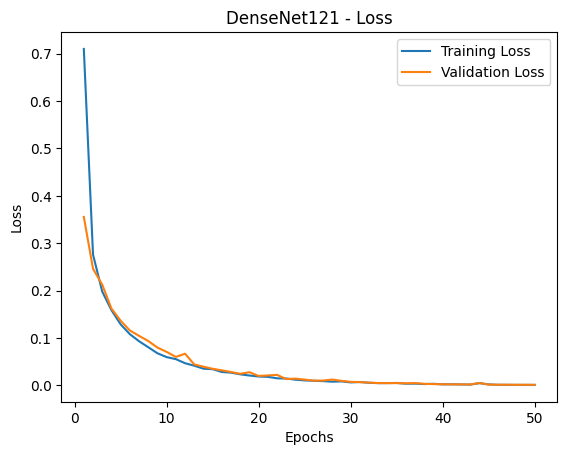

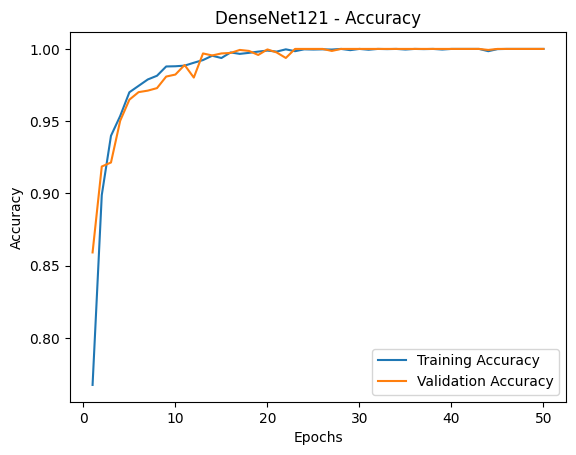

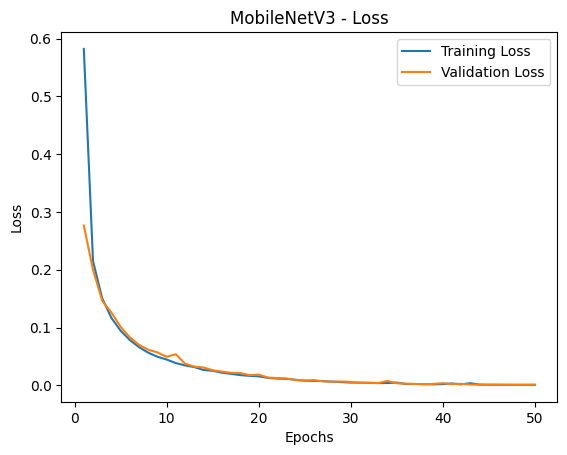

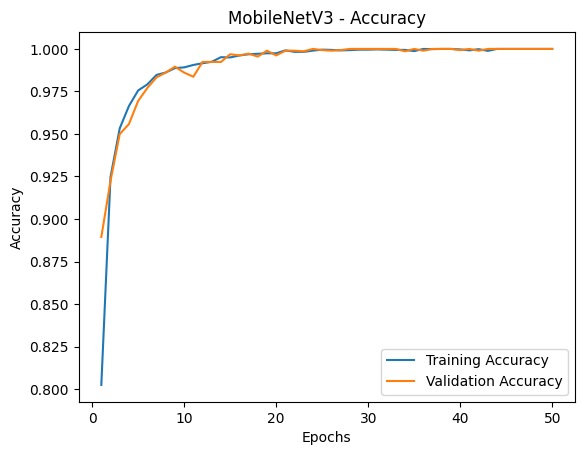

In [10]:
# Function to plot training and validation metrics
def plot_training_history(history, model_name):
    """
    Plots training and validation loss/accuracy for a model.
    Args:
        history: Dictionary containing training history data.
        model_name: Name of the model (for titles and saving plots).
    """
    # Extract data from dictionary
    loss = history['loss']
    val_loss = history['val_loss']
    accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']
    epochs = range(1, len(loss) + 1)

    # Plot Loss
    plt.figure()
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'reports/graphs/{model_name}_loss.png')
    plt.show()

    # Plot Accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f'reports/graphs/{model_name}_accuracy.png')
    plt.show()

# Load training histories
resnet_history = np.load("models/resnet50_model_history.npy", allow_pickle=True).item()
densenet_history = np.load("models/densenet121_model_history.npy", allow_pickle=True).item()
mobilenet_history = np.load("models/mobilenetv3_model_history.npy", allow_pickle=True).item()

# Plot for each model
plot_training_history(resnet_history, "ResNet50")
plot_training_history(densenet_history, "DenseNet121")
plot_training_history(mobilenet_history, "MobileNetV3")


Confusion Matrices

Found 1095 images belonging to 10 classes.
Found 1095 images belonging to 10 classes.
Found 1095 images belonging to 10 classes.
35/35 [==============================] - 40s 1s/step


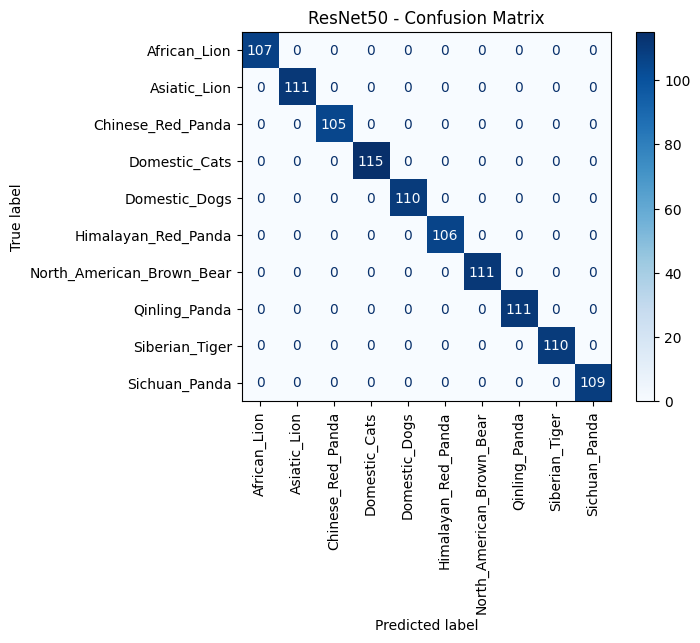

35/35 [==============================] - 45s 1s/step


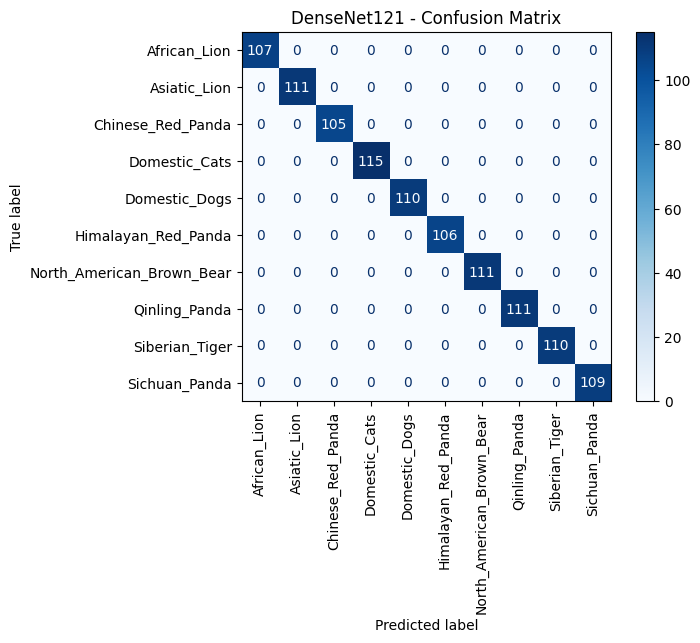

35/35 [==============================] - 13s 343ms/step


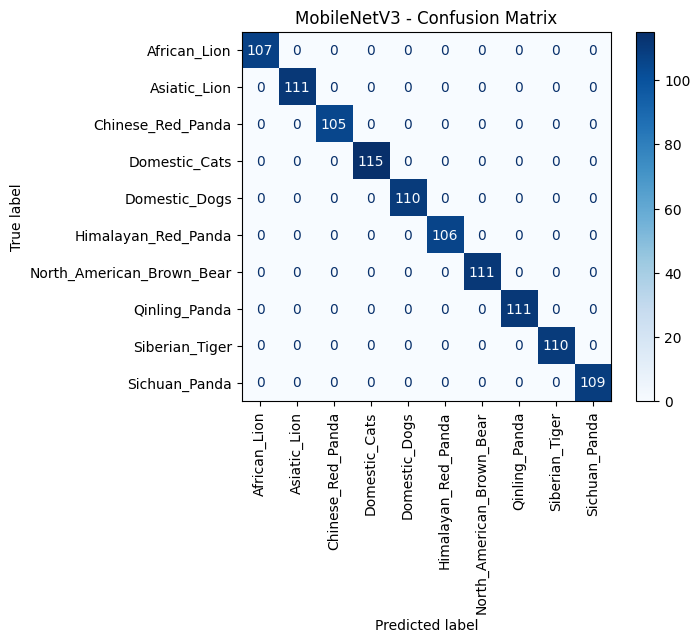

In [8]:
# Function to plot confusion matrix
def plot_confusion_matrix(model, test_gen, model_name):
    """
    Generates and displays a confusion matrix.
    Args:
        model: Trained Keras model.
        test_gen: Test data generator.
        model_name: Name of the model.
    """
    # Get predictions
    y_true = test_gen.classes
    y_pred = np.argmax(model.predict(test_gen), axis=-1)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_gen.class_indices.keys())
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.savefig(f'reports/graphs/{model_name}_confusion_matrix.png')
    plt.show()

# Load models
resnet_model = load_model("models/resnet50_model.h5")
densenet_model = load_model("models/densenet121_model.h5")
mobilenet_model = load_model("models/mobilenetv3_model.h5")

# Recreate test data generators
test_dir = "data/test"
test_datagen_resnet = ImageDataGenerator(preprocessing_function=preprocess_input_resnet)
test_generator_resnet = test_datagen_resnet.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False
)

test_datagen_densenet = ImageDataGenerator(preprocessing_function=preprocess_input_densenet)
test_generator_densenet = test_datagen_densenet.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False
)

test_datagen_mobilenet = ImageDataGenerator(preprocessing_function=preprocess_input_mobilenet)
test_generator_mobilenet = test_datagen_mobilenet.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False
)

# Plot confusion matrices
plot_confusion_matrix(resnet_model, test_generator_resnet, "ResNet50")
plot_confusion_matrix(densenet_model, test_generator_densenet, "DenseNet121")
plot_confusion_matrix(mobilenet_model, test_generator_mobilenet, "MobileNetV3")

Comparative Analysis

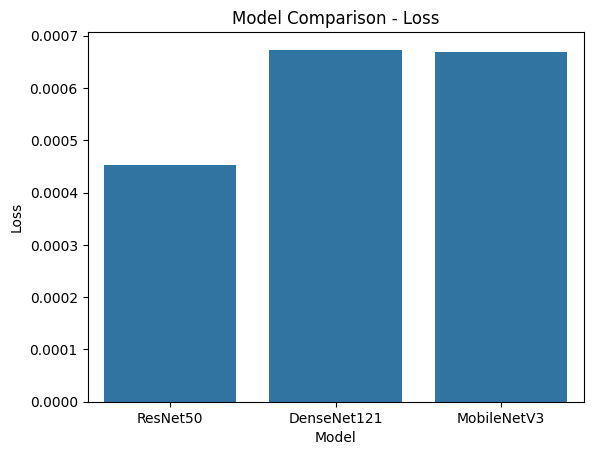

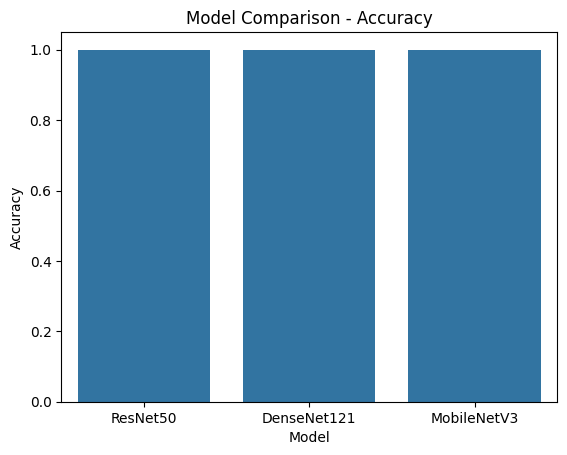

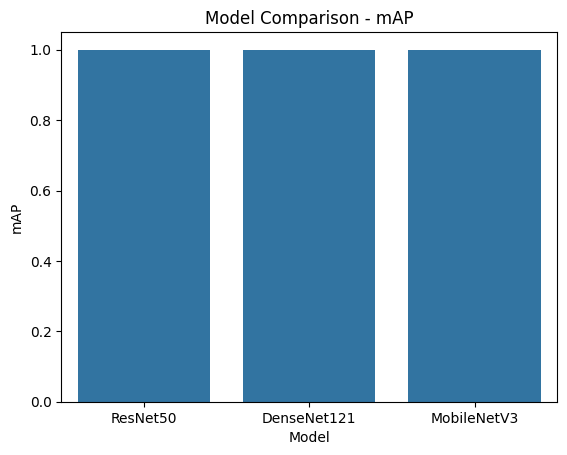

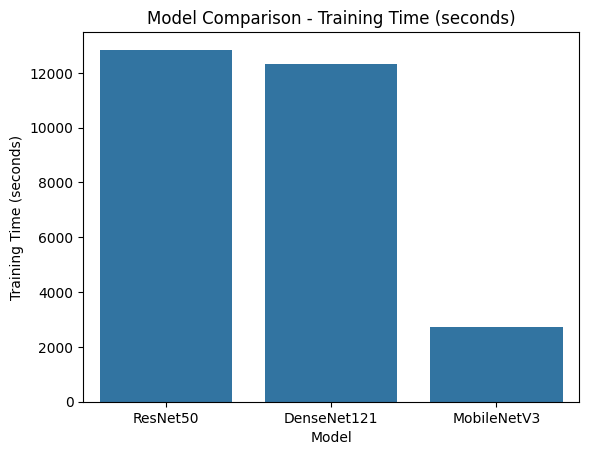

In [9]:
# Bar plot for comparison
metrics = ["Loss", "Accuracy", "mAP", "Training Time (seconds)"]
for metric in metrics:
    plt.figure()
    sns.barplot(x="Model", y=metric, data=evaluation_results)
    plt.title(f'Model Comparison - {metric}')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.savefig(f'reports/graphs/comparison_{metric.lower().replace(" ", "_")}.png')
    plt.show()

### **Model Comparison**

| *Criteria*            | *ResNet50*                                                                                       | *DenseNet121*                                                                                   | *MobileNetV3*                                                                                  |
|--------------------------|---------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------|
| *Training Time*        | Longest training time, slightly longer than DenseNet121.                                          | Slightly faster than ResNet50 but still computationally expensive.                               | Much faster training time, suitable for resource-constrained environments.                       |
| *Accuracy*             | High accuracy (close to 1.0), minimal overfitting.                                               | High accuracy (close to 1.0), minimal overfitting.                                               | High accuracy (close to 1.0), minimal overfitting.                                               |
| *Loss*                 | Very low training and validation loss, slightly better than MobileNetV3.                         | Very low training and validation loss, comparable to ResNet50.                                   | Low training and validation loss, slightly higher than ResNet50 and DenseNet121.                |
| *Confusion Matrix*     | Perfect predictions, no misclassifications.                                                      | Perfect predictions, no misclassifications.                                                      | Perfect predictions, no misclassifications.                                                      |
| *Strengths*            | Excellent performance, robust predictions, low loss, high accuracy.                              | Comparable performance to ResNet50 with slightly faster training.                                | Lightweight, faster training, and competitive performance.                                       |
| *Weaknesses*           | Longest training time, less suitable for resource-constrained scenarios.                         | Computationally expensive compared to MobileNetV3.                                               | Slightly higher loss, though it does not significantly impact accuracy.                          |
| *Recommendation*       | Best for tasks requiring robust performance and accuracy, where resources and time are abundant. | A balanced choice for high accuracy with faster training compared to ResNet50.                   | Best for rapid training or deployment in resource-constrained environments (e.g., mobile/edge). |

### **Final Conclusion**

After comparing ResNet50, DenseNet121, and MobileNetV3 based on training time, accuracy, loss, and confusion matrices, we would like to conclude:

1. *Best Model for High Accuracy*  
   - *ResNet50* and *DenseNet121* are great for achieving the highest accuracy.  
   - ResNet50 is slightly better at reducing loss but takes the longest to train.  
   - DenseNet121 offers similar accuracy and faster training, making it more efficient than ResNet50.

2. *Best Model for Fast Training*  
   - *MobileNetV3* is much faster to train and still achieves high accuracy.  
   - It’s perfect for applications on mobile devices or situations where resources and time are limited.

3. *Which Model to Choose?*
   - *Use ResNet50 or DenseNet121*:
     - If you need the best accuracy and have enough time and computational resources.
     - Example: Research projects or applications needing very precise results.
   - *Use MobileNetV3*:
     - If you need faster training or need to deploy the model on devices with limited hardware.
     - Example: Mobile apps or IoT systems.

4. *Evidence from Results*
   - All models performed perfectly, with no misclassifications in the testing dataset (as shown in the confusion matrices).
   - Training loss and accuracy graphs show all models trained well without overfitting.

### **Final Recommendation**
- *Choose ResNet50 or DenseNet121* for tasks where accuracy matters the most.  
- *Choose MobileNetV3* if you need faster training and lower resource usage.  